# Exploring RXTE spectral observations of Eta Car

## Learning Goals

By the end of this tutorial, you will:

- Know how to find and use observation tables hosted by HEASARC.
- Be able to search for RXTE observations of a named source.
- Understand how to retrieve the information necessary to access RXTE spectra stored in the HEASARC S3 bucket.
- Be capable of downloading and visualizing retrieved spectra.
- Perform basic spectral fits and explore how spectral properties change with time.


## Introduction
This notebook demonstrates an analysis of archival Rossi X-ray Timing Explorer (RXTE) Proportional Counter Array (PCA) data, particularly spectra of Eta Car.

The RXTE archive contains standard data products that can be used without re-processing the data. These are described in detail in the [RXTE ABC guide](https://heasarc.gsfc.nasa.gov/docs/xte/abc/front_page.html).

We find all the standard spectra and then load, visualize, and fit them with pyXspec.

### Inputs

- The name of the source we are going to explore RXTE observations of; Eta Car.

### Outputs

- Downloaded source and background spectra.
- Downloaded spectral response files.
- Visualization of all spectra and fitted spectral models.
- A figure showing powerlaw model parameter distributions from all spectral fits.
- A figure showing how fitted model parameters vary with time.

### Runtime

As of 9th October 2025, this notebook takes ~10m to run to completion on Fornax, using the 'small' server with 8GB RAM/ 2 cores.

## Imports & Environments
We need the following Python modules:

In [1]:
import os

import astropy.io.fits as fits
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import xspec
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.units import Quantity
from astroquery.heasarc import Heasarc
from matplotlib.ticker import FuncFormatter
from s3fs import S3FileSystem
from tqdm import tqdm

%matplotlib inline

## Global Setup

### Functions

In [2]:
# This cell will be automatically collapsed when the notebook is rendered, which helps
#  to hide large and distracting functions while keeping the notebook self-contained
#  and leaving them easily accessible to the user

### Constants

### Configuration

The only configuration we do is to set up the root directory where we will store downloaded data.

In [3]:
if os.path.exists("../../../_data"):
    ROOT_DATA_DIR = "../../../_data/RXTE/"
else:
    ROOT_DATA_DIR = "RXTE/"

***

## 1. Finding the data

To identify the relevant RXTE data, we can use [Xamin](https://heasarc.gsfc.nasa.gov/xamin/), the HEASARC web portal, the Virtual Observatory (VO) python client `pyvo`, or **the AstroQuery module** (our choice for this demonstration).

### Using AstroQuery to find the HEASARC table that lists all of RXTE's observations

Using the `Heasarc` object from AstroQuery, we can easily search through all of HEASARC's catalog holdings. In this
case we need to find what we refer to as a 'master' catalog/table, which summarizes all RXTE observations present in
our archive. We can do this by passing the `master=True` keyword argument to the `list_catalogs` method.

In [4]:
table_name = Heasarc.list_catalogs(keywords="xte", master=True)[0]["name"]
table_name

np.str_('xtemaster')

### Identifying RXTE observations of Eta Car

Now that we have identified the HEASARC table that contains information on RXTE pointings, we're going to search
it for observations of **Eta Car**.

For convenience, we pull the coordinate of Eta Car from the CDS name resolver functionality built into AstroPy's
`SkyCoord` class.

```{caution}
You should always carefully vet the positions you use in your own work!
```

In [5]:
# Get the coordinate for Eta Car
pos = SkyCoord.from_name("Eta Car")
pos

<SkyCoord (ICRS): (ra, dec) in deg
    (161.2647742, -59.6844309)>

Then we can use the `query_region` method of `Heasarc` to search for observations with a central coordinate that
falls within a radius of $0.2^{\prime}$ of Eta Car.

```{hint}
Each HEASARC catalog has its own default search radius, but we select $0.2^{\prime}$ to limit the number of results.
You should carefully consider the search radius you use for your own science case!
```

In [6]:
valid_obs = Heasarc.query_region(
    pos, catalog=table_name, radius=Quantity(0.2, "arcmin")
)
valid_obs

obsid,prnb,status,pi_lname,pi_fname,target_name,ra,dec,time,duration,exposure,__row
,,,,,,deg,deg,d,s,s,
object,int32,object,object,object,object,float64,float64,float64,float64,float64,object
94002-01-15-00,94002,archived,TOO,PUBLIC,ETA_CAR,161.2650,-59.6845,55000.4322,2518,1197,16751
93002-01-17-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54398.83492,2179,924,16752
93002-02-52-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54808.7048,1582,905,16753
93002-02-53-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54810.66671,1510,829,16754
93002-02-54-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54812.85572,1430,927,16755
93002-01-47-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54606.98389,3246,863,16756
93002-02-55-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54814.29519,2168,771,16757
93002-02-56-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54816.35667,2442,885,16758


Alternatively, if you wished to place extra constraints on the search, you could use the more complex but more powerful
`query_tap` method to pass a full Astronomical Data Query Language (ADQL) query. This demonstration runs the same
spatial query as before but also includes a stringent exposure time requirement; you might do this to try and only
select the highest signal-to-noise observations.

Note that we call the `to_table` method on the result of the query to convert the result into an AstroPy table, which
is the form required to pass to the `locate_data` method (see the next section).

In [7]:
query = (
    "SELECT * "
    "from {c} as cat "
    "where contains(point('ICRS',cat.ra,cat.dec), circle('ICRS',{ra},{dec},0.0033))=1 "
    "and cat.exposure > 1200".format(ra=pos.ra.value, dec=pos.dec.value, c=table_name)
)

alt_obs = Heasarc.query_tap(query).to_table()
alt_obs

__row,pi_lname,pi_fname,pi_no,prnb,cycle,subject_category,target_name,time_awarded,ra,dec,priority,tar_no,obsid,time,duration,exposure,status,scheduled_date,observed_date,processed_date,archived_date,hexte_anglea,hexte_angleb,hexte_dwella,hexte_dwellb,hexte_energya,hexte_energyb,hexte_modea,hexte_modeb,pca_config1,pca_config2,pca_config3,pca_config4,pca_config5,pca_config6,lii,bii,__x_ra_dec,__y_ra_dec,__z_ra_dec
,,,,,,,,s,deg,deg,,,,d,s,s,,d,d,d,d,,,,,,,,,,,,,,,deg,deg,,,
object,object,object,int32,int32,int16,object,object,float64,float64,float64,int16,int16,object,float64,float64,float64,object,float64,float64,int32,int32,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64
16769,CORCORAN,MICHAEL,196,93002,12,STARS,ETA_CAR,85000.0,161.2650,-59.6845,1,2,93002-02-66-00,54836.05479,2428,1267,archived,54836.05479,54836.05479,54845,55211,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8US_256_DX1F,E_8US_256_DX1F,STANDARD1,STANDARD2,GOODXENON1_2S,GOODXENON2_2S,IDLE,IDLE,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16771,CORCORAN,MICHAEL,196,93002,12,STARS,ETA_CAR,85000.0,161.2650,-59.6845,1,2,93002-02-68-00,54840.44851,2842,1335,archived,54840.44851,54840.44851,54850,55218,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8US_256_DX1F,E_8US_256_DX1F,STANDARD1,STANDARD2,GOODXENON1_2S,GOODXENON2_2S,IDLE,IDLE,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16777,CORCORAN,MICHAEL,196,93002,12,STARS,ETA_CAR,85000.0,161.2650,-59.6845,1,2,93002-02-73-00,54850.24669,3308,1651,archived,54850.24669,54850.24669,54859,55225,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8US_256_DX1F,E_8US_256_DX1F,STANDARD1,STANDARD2,GOODXENON1_2S,GOODXENON2_2S,IDLE,IDLE,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16789,CORCORAN,MICHAEL,196,93002,12,STARS,ETA_CAR,85000.0,161.2650,-59.6845,1,2,93002-02-84-00,54872.22313,2542,1283,archived,54872.22313,54872.22313,54880,55247,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8US_256_DX1F,E_8US_256_DX1F,STANDARD1,STANDARD2,GOODXENON1_2S,GOODXENON2_2S,IDLE,IDLE,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16797,TOO,PUBLIC,0,94002,13,STARS,ETA_CAR,1310.0,161.2650,-59.6845,0,1,94002-01-05-00,54930.46883,1725,1313,archived,54930.46883,54930.46883,54938,--,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8us_256_DX1F,E_8us_256_DX1F,GOODXENON1_2S,GOODXENON2_2S,GOODVLE1_2S,STANDARD1B,STANDARD2F,GOODVLE2_2S,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16799,TOO,PUBLIC,0,94002,13,STARS,ETA_CAR,1210.0,161.2650,-59.6845,0,1,94002-01-07-00,54944.20307,2695,1207,archived,54944.20307,54944.20307,54952,--,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8us_256_DX1F,E_8us_256_DX1F,GOODXENON1_2S,GOODXENON2_2S,GOODVLE1_2S,STANDARD1B,STANDARD2F,GOODVLE2_2S,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16803,CORCORAN,MICHAEL,196,93002,12,STARS,ETA_CAR,65000.0,161.2650,-59.6845,1,1,93002-01-49-00,54620.98435,2615,1504,archived,54620.98435,54620.98435,54629,54994,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8US_256_DX1F,E_8US_256_DX1F,STANDARD1,STANDARD2,GOODXENON1_2S,GOODXENON2_2S,IDLE,IDLE,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16804,TOO,PUBLIC,0,94002,13,STARS,ETA_CAR,1400.0,161.2650,-59.6845,0,1,94002-01-11-00,54971.98391,2823,1401,archived,54971.98391,54971.98391,54980,--,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8us_256_DX1F,E_8us_256_DX1F,GOODXENON1_2S,GOODXENON2_2S,GOODVLE1_2S,STANDARD1B,STANDARD2F,GOODVLE2_2S,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778


### Using AstroQuery to fetch datalinks to RXTE datasets

We've already figured out which HEASARC table to pull RXTE observation information from, and then used that table
to identify specific observations that might be relevant to our target source (Eta Car). Our next step is to pinpoint
the exact location of files from each observation that we can use to visualize the spectral emission of our source.

Just as in the last two steps, we're going to make use of AstroQuery. The difference is, rather than dealing with tables of
observations, we now need to construct 'datalinks' to places where specific files for each observation are stored. In
this demonstration we're going to pull data from the HEASARC 'S3 bucket', an Amazon-hosted open-source dataset
containing all of HEASARC's data holdings.

In [8]:
data_links = Heasarc.locate_data(valid_obs, "xtemaster")
data_links

ID,access_url,sciserver,aws,content_length,error_message
,,,,byte,
object,object,str50,str63,int64,object
ivo://nasa.heasarc/xtemaster?16751,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO13/P94002//94002-01/,/FTP/xte/data/archive/AO13/P94002/94002-01/,s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01/,--,
ivo://nasa.heasarc/xtemaster?16751,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO13/P94002/94002-01-15-00//,/FTP/xte/data/archive/AO13/P94002/94002-01-15-00/,s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00/,--,
ivo://nasa.heasarc/xtemaster?16751,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO13/P94002/94002-01-15-00A//,/FTP/xte/data/archive/AO13/P94002/94002-01-15-00A/,s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00A/,--,
ivo://nasa.heasarc/xtemaster?16751,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO13/P94002/94002-01-15-00Z//,/FTP/xte/data/archive/AO13/P94002/94002-01-15-00Z/,s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00Z/,--,
ivo://nasa.heasarc/xtemaster?16751,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO13/P94002//94002-01-15-00/,/FTP/xte/data/archive/AO13/P94002/94002-01-15-00/,s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00/,--,
ivo://nasa.heasarc/xtemaster?16752,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO12/P93002//93002-01/,/FTP/xte/data/archive/AO12/P93002/93002-01/,s3://nasa-heasarc/xte/data/archive/AO12/P93002/93002-01/,--,
ivo://nasa.heasarc/xtemaster?16752,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO12/P93002/93002-01-17-00//,/FTP/xte/data/archive/AO12/P93002/93002-01-17-00/,s3://nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-17-00/,--,
ivo://nasa.heasarc/xtemaster?16752,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO12/P93002/93002-01-17-00A//,/FTP/xte/data/archive/AO12/P93002/93002-01-17-00A/,s3://nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-17-00A/,--,


## 2. Acquiring the data
We now know where the relevant RXTE-PCA spectra are stored in the HEASARC S3 bucket, and will proceed to download
them for local use.

```{caution}
***Many workflows are being adapted to stream remote data directly into memory*** (RAM), rather than
downloading it onto disk storage, *then* reading into memory - PyXspec does not yet support this way of
operating, but our demonstrations will be updated when it does.
```


### The easiest way to download data

At this point, you may wish to simply download the entire set of files for all the observations you've identified.
That is easily achieved using AstroQuery, with the `download_data` method of `Heasarc`, we just need to pass
the datalinks we found in the previous step.

We demonstrate this approach using the first three entries in the datalinks table, but in the following sections will
demonstrate a more complicated, but targeted, approach that will let us download only the RXTE-PCA spectra and their
supporting files:

In [9]:
Heasarc.download_data(data_links[:3], host="aws", location=ROOT_DATA_DIR)

INFO: Downloading data AWS S3 ... [astroquery.heasarc.core]
INFO: Enabling anonymous cloud data access ... [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01/ [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00/ [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00A/ [astroquery.heasarc.core]


### Downloading only RXTE-PCA spectra

Rather than downloading all files for all our observations, we will now _only_ fetch those that are directly
relevant to what we want to do in this notebook - this method is a little more involved than using AstroQuery, but
it is more efficient and flexible.

We make use of a Python module called `s3fs`, which allows us to interact with files stored on Amazon's S3
platform through Python commands.

We create an `S3FileSystem` object, which lets us interact with the S3 bucket as if it were a filesystem.

```{hint}
Note the `anon=True` argument, as attempting access to the HEASARC S3 bucket will fail without it!
```

In [10]:
s3 = S3FileSystem(anon=True)

Now we identify the specific files we want to download. The datalink table tells us the AWS S3 'path' (the Uniform
Resource Identifier, or URI) to each observation's data directory, the [RXTE documentation](https://heasarc.gsfc.nasa.gov/docs/xte/start_guide.html#directories)
tells us that the automatically generated data products are stored in a subdirectory called 'stdprod', and the
[RXTE Guest Observer Facility (GOF) standard product guide](https://heasarc.gsfc.nasa.gov/docs/xte/recipes/stdprod_guide.html)
shows us that PCA spectra and supporting files are named as:

- **xp{ObsID}_s2.pha** - the spectrum automatically generated for the target of the RXTE observation.
- **xp{ObsID}_b2.pha** - the background spectrum companion to the source spectrum.
- **xp{ObsID}.rsp** - the supporting file that defines the response curve (sensitivity over energy range) and redistribution matrix (a mapping of channel to energy) for the RXTE-PCA instrument during the observation.

We set up a file patterns for these three files for each datalink entry, and then use the `expand_path` method of
our previously-set-up S3 filesystem object to find all the files that match the pattern. This is useful because the
RXTE datalinks we found might include sections of a particular observation that do not have standard products
generated, for instance, the slewing periods before/after the telescope was aligned on target.

In [11]:
all_file_patt = [
    os.path.join(base_uri, "stdprod", fp)
    for base_uri in data_links["aws"].value
    for fp in ["xp*_s2.pha*", "xp*_b2.pha*", "xp*.rsp*"]
]

val_file_uris = s3.expand_path(all_file_patt)
val_file_uris[:10]

['nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-01-00/stdprod/xp93002010100.rsp.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-01-00/stdprod/xp93002010100_b2.pha.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-01-00/stdprod/xp93002010100_s2.pha.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-02-00/stdprod/xp93002010200.rsp.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-02-00/stdprod/xp93002010200_b2.pha.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-02-00/stdprod/xp93002010200_s2.pha.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-03-00/stdprod/xp93002010300.rsp.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-03-00/stdprod/xp93002010300_b2.pha.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-03-00/stdprod/xp93002010300_s2.pha.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-04-00/stdprod/xp93002010400.rsp.gz']

Now we can just use the `get` method of our S3 filesystem object to download all the valid spectral files!

In [12]:
spec_file_path = os.path.join(ROOT_DATA_DIR, "rxte_pca_demo_spec")
ret = s3.get(val_file_uris, spec_file_path)

## 3. Reading the data into PyXspec

We have acquired the spectra and their supporting files and will perform very basic visualizations and model fitting
using the Python wrapper to the ubiquitous X-ray spectral fitting code, XSPEC. To learn more advanced uses of
pyXspec please refer to the [documentation](https://heasarc.gsfc.nasa.gov/docs/software/xspec/python/html/index.html),
or examine other tutorials in this repository.

We set the ```chatter``` parameter to 0 to reduce the printed text given the large number of files we are reading.

### Configuring PyXspec

In [13]:
xspec.Xset.chatter = 0

# Other xspec settings
xspec.Plot.area = True
xspec.Plot.xAxis = "keV"
xspec.Plot.background = True
xspec.Fit.statMethod = "cstat"
xspec.Fit.query = "no"
xspec.Fit.nIterations = 500

# Store the current working directory
cwd = os.getcwd()

### Reading and fitting the spectra


This code will read in the spectra and fit a simple power-law model with default start values (we do not necessarily
recommend this model for this type of source, nor leaving parameters set to default values). It also extracts the
spectrum data points, fitted model data points and the fitted model parameters, for plotting purposes.

Note that we move into the directory where the spectra are stored. This is because the main source spectra files
have relative paths to the background and response files in their headers, and if we didn't move into the
directory XSPEC would not be able to find them.

In [14]:
# We move into the directory where the spectra are stored
os.chdir(spec_file_path)

# The spectra will be saved in a list
spec_plot_data = []
fit_plot_data = []
pho_inds = []
norms = []

# Picking out just the source spectrum files
src_sp_files = [rel_uri.split("/")[-1] for rel_uri in val_file_uris if "_s2" in rel_uri]

# Iterating through all the source spectra
with tqdm(desc="Loading/fitting RXTE spectra", total=len(src_sp_files)) as onwards:
    for sp_name in src_sp_files:
        # Clear out the previously loaded dataset and model
        xspec.AllData.clear()
        xspec.AllModels.clear()

        # Loading in the spectrum
        spec = xspec.Spectrum(sp_name)

        # Set up a powerlaw and then fit to the current spectrum
        model = xspec.Model("powerlaw")
        xspec.Fit.perform()

        # Extract the parameter values
        pho_inds.append(model.powerlaw.PhoIndex.values[:2])
        norms.append(model.powerlaw.norm.values[:2])

        # Create an XSPEC plot (not visualizaed here) and then extract the information
        #  required to let us plot it using matplotlib
        xspec.Plot("data")
        spec_plot_data.append(
            [xspec.Plot.x(), xspec.Plot.xErr(), xspec.Plot.y(), xspec.Plot.yErr()]
        )
        fit_plot_data.append(xspec.Plot.model())

        onwards.update(1)

os.chdir(cwd)

pho_inds = np.array(pho_inds)
norms = np.array(norms)

Loading/fitting RXTE spectra: 100%|██████████| 317/317 [00:23<00:00, 13.61it/s]


### Visualizing the spectra

Using the data extracted in the last step, we can plot the spectra and fitted models using matplotlib.

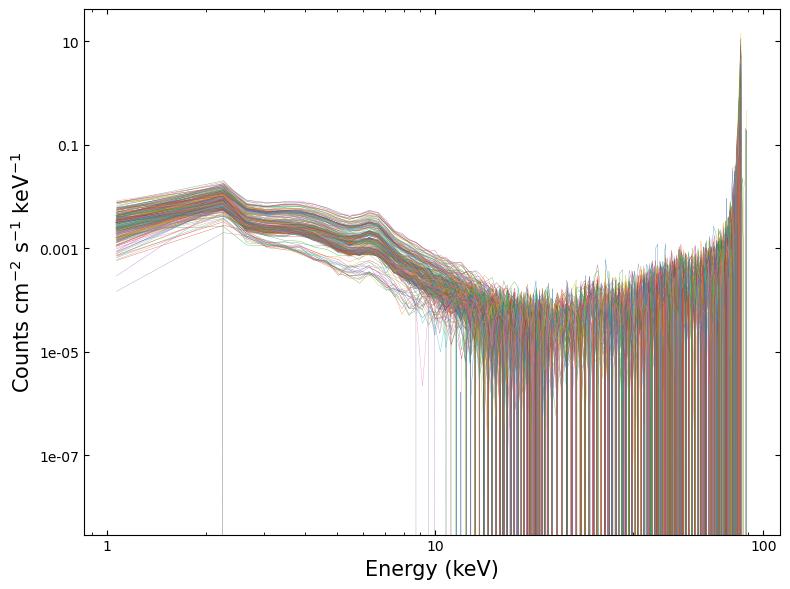

In [15]:
# Now we plot the spectra
fig = plt.figure(figsize=(8, 6))

plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

for x, xerr, y, yerr in spec_plot_data:
    plt.plot(x, y, linewidth=0.2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Energy (keV)", fontsize=15)
plt.ylabel(r"Counts cm$^{-2}$ s$^{-1}$ keV$^{-1}$", fontsize=15)

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

plt.tight_layout()
plt.show()

### Visualizing the fitted models

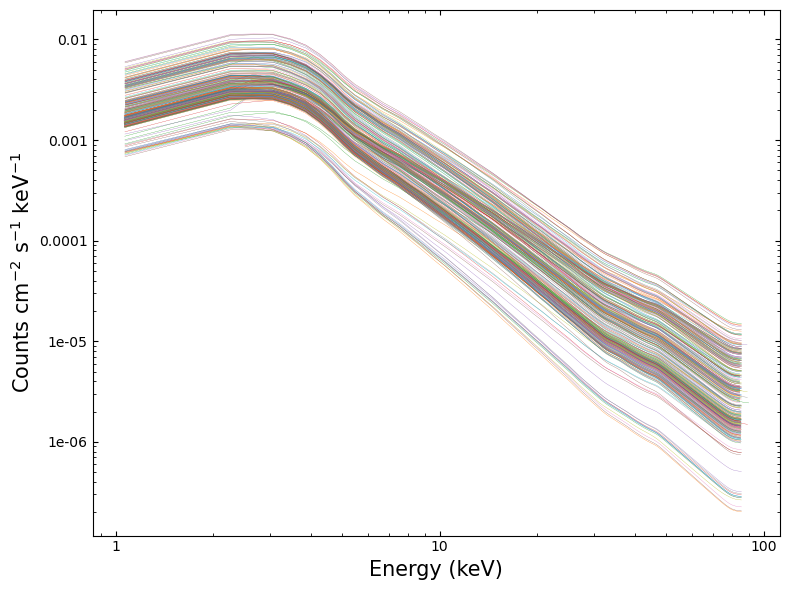

In [16]:
fig = plt.figure(figsize=(8, 6))

plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

for fit_ind, fit in enumerate(fit_plot_data):
    plt.plot(spec_plot_data[fit_ind][0], fit, linewidth=0.2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Energy (keV)", fontsize=15)
plt.ylabel(r"Counts cm$^{-2}$ s$^{-1}$ keV$^{-1}$", fontsize=15)

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

plt.tight_layout()
plt.show()

## 4. Exploring model fit results

As we have fit models to all these spectra, and retrieved their parameter's values, we should take a look at them!

Exactly what you do at this point will depend entirely upon your science case, and the type of object you've been
analysing, but any analysis will benefit from an initial examination of the fitted parameter values (particularly if
you have fit hundreds of spectra, as we have).

### Fitted model parameter distributions

This shows us what the distributions of the Photon Index (related to the power law slope) and the
model normalization look like. We can see that the distributions are not particularly symmetric and Gaussian-looking.

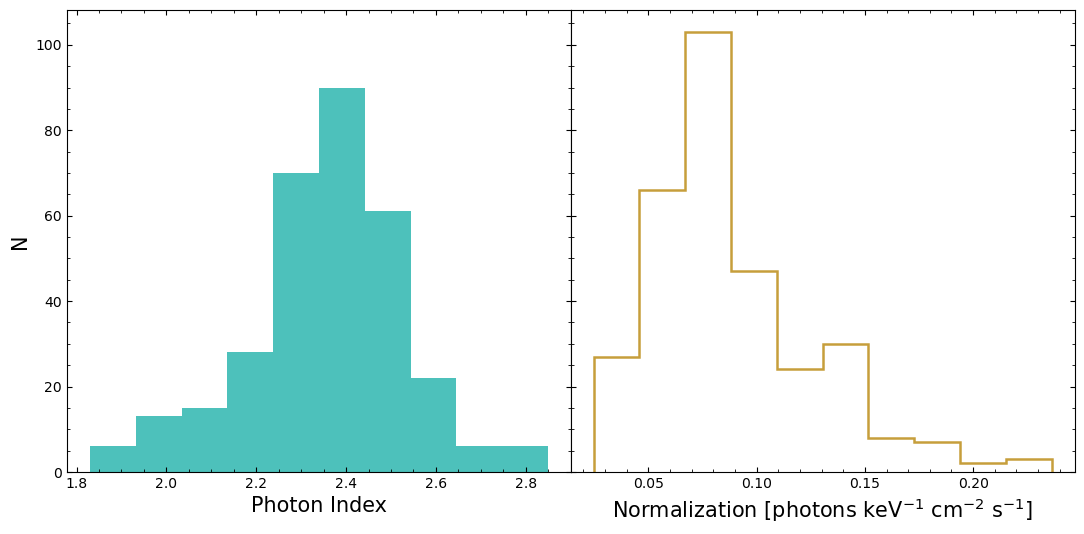

In [17]:
fig, ax_arr = plt.subplots(1, 2, sharey="row", figsize=(13, 6))
fig.subplots_adjust(wspace=0.0)

for ax_inds, ax in np.ndenumerate(ax_arr):
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True)

ax_arr[0].hist(pho_inds[:, 0], alpha=0.8, color="lightseagreen", histtype="stepfilled")
ax_arr[0].set_xlabel("Photon Index", fontsize=15)
ax_arr[0].set_ylabel("N", fontsize=15)

ax_arr[1].hist(norms[:, 0], alpha=0.8, color="darkgoldenrod", histtype="step", lw=1.8)
ax_arr[1].set_xlabel(
    r"Normalization [photons keV$^{-1}$ cm$^{-2}$ s$^{-1}$]", fontsize=15
)

plt.show()

### Do model parameters vary with time?

That might then make us wonder if the reason we're seeing these non-Gaussian distributions is due to Eta Car's
X-ray emission varying with time over the course of RXTE's campaign? Some kinds of X-ray source are extremely
variable, and we know that Eta Car's X-ray emission is variable in other wavelengths.

As a quick check, we can retrieve the start time of each RXTE observation from the source spectra, and then plot
the model parameter values against the time of their observation. In this case, we extract the modified Julian
date (MJD) reference time, the time system, and the start time (which is currently relative to the reference time) -
combining this information lets us convert the start time into a datetime object.

In [18]:
obs_start = []

for loc_sp in src_sp_files:
    with fits.open(os.path.join(spec_file_path, loc_sp)) as speco:
        cur_ref = Time(
            speco[0].header["MJDREFI"] + speco[0].header["MJDREFF"], format="mjd"
        )
        cur_tstart = Quantity(speco[0].header["TSTART"], "s")
        start_dt = (
            cur_ref
            + TimeDelta(
                cur_tstart, format="sec", scale=speco[0].header["TIMESYS"].lower()
            )
        ).to_datetime()
        obs_start.append(start_dt)

Now we actually plot the Photon Index and Normalization values against the start times, and we can see an extremely
strong indication of time varying X-ray emission from Eta Car:

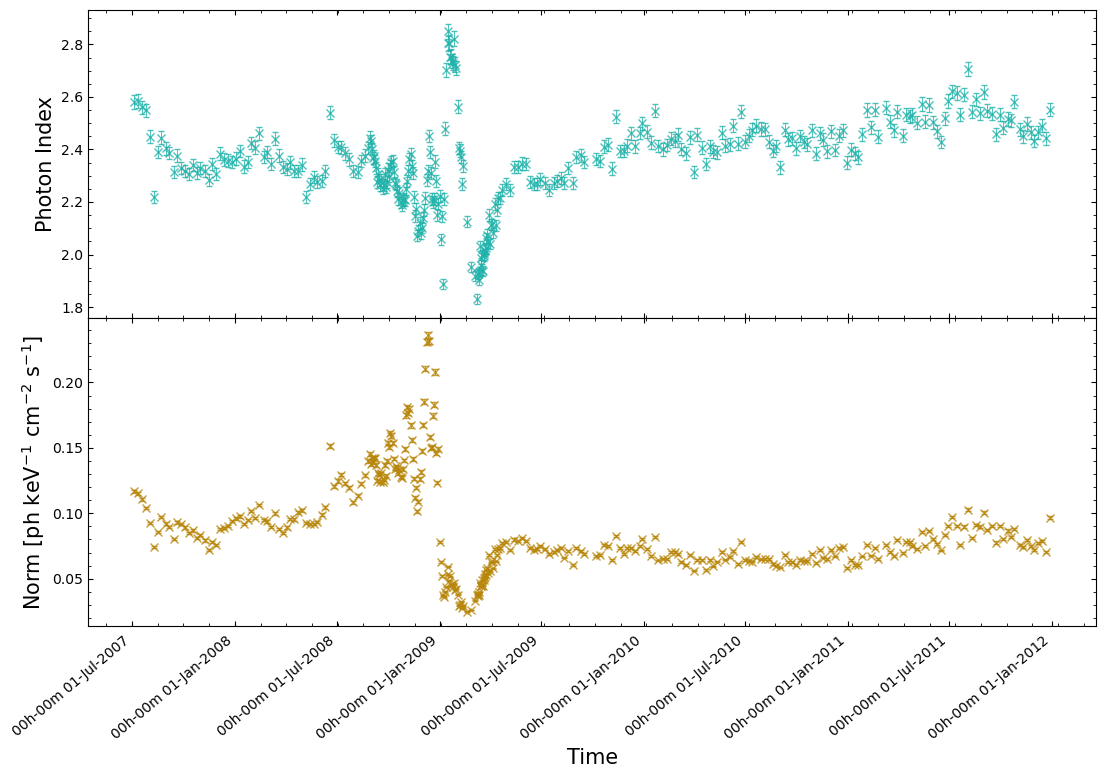

In [19]:
fig, ax_arr = plt.subplots(2, 1, sharex="col", figsize=(13, 8))
fig.subplots_adjust(hspace=0.0)

for ax_inds, ax in np.ndenumerate(ax_arr):
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True)

ax_arr[0].errorbar(
    obs_start,
    pho_inds[:, 0],
    yerr=pho_inds[:, 1],
    fmt="x",
    capsize=2,
    lw=0.7,
    alpha=0.8,
    color="lightseagreen",
)

ax_arr[0].set_ylabel("Photon Index", fontsize=15)
ax_arr[0].xaxis.set_major_formatter(mdates.DateFormatter("%Hh-%Mm %d-%b-%Y"))

ax_arr[1].errorbar(
    obs_start,
    norms[:, 0],
    yerr=norms[:, 1],
    fmt="x",
    capsize=2,
    lw=0.7,
    alpha=0.8,
    color="darkgoldenrod",
)

ax_arr[1].set_ylabel(r"Norm [ph keV$^{-1}$ cm$^{-2}$ s$^{-1}$]", fontsize=15)
ax_arr[1].xaxis.set_major_formatter(mdates.DateFormatter("%Hh-%Mm %d-%b-%Y"))
ax_arr[1].set_xlabel("Time", fontsize=15)

for label in ax_arr[1].get_xticklabels(which="major"):
    label.set(
        y=label.get_position()[1] - 0.01, rotation=40, horizontalalignment="right"
    )

plt.show()

***



## About this notebook

Author: Tess Jaffe, HEASARC Chief Archive Scientist.

Author: David J Turner, HEASARC Staff Scientist.

Updated On: 2026-01-09

### Additional Resources

### Acknowledgements


### References